# Introduction

This package provides functions to perform least-squares fits of quasinormal modes to ringdown waveforms. As long as you have a timeseries (either a single array or a dictionary of spherical-harmonic modes) you can use the functions provided by this package to perform fits.

In addition, some waveform classes are provided for convenience. These provide flux calculations and frame transformations which can be useful when doing ringdown analyses. Currently, there are three types of waveform class which the user can initialise:

 - **SXS**: Loads a waveform from the SXS catalog. This makes use of the `sxs` Python package to automatically download the simulation, so that you only need to specify the ID. 

 - **Surrogate**: Initializes a waveform generated by a surrogate. Currently implemented are **NRSur7dq4** and **NRHybSur3dq8**.

 - **Custom**: The user provides a dictionary of modes. 

The core fitting functions are all available in the `qnmfits.py` file. The waveform classes are in the `Waveforms` folder, and each inherit functions from `Waveforms/Base.BaseClass`.

# Analysing a SXS waveform

To demonstrate the features of the code we will work with the simulation SXS:BBH:0305, but everything will apply to a generic waveform.

## Class initialization

The only required argument for an SXS waveform is a simulation ID. However, it is a good idea to also change the zero-time to something more useful. Here we use the peak of the absolute value of the (2,2) mode (see the `Simulation` docstring for other options, including the ability to transform the modes with a rotation).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import os
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from cmcrameri import cm

In [3]:

qnmfits.download_cook_data()


sims = []
ids = [305]#, 1475, 1476, 1477, 1481, 1492, 1495, 1497, 1499, 1500, 1501, 1502, 1503, 1506, 1507, 1509]
for id in ids:
    sims.append(qnmfits.SXS(ID=id, zero_time=(2,2)))
    
sim = sims[0]


KerrQNM_08.h5 already downloaded.
KerrQNM_09.h5 already downloaded.


c:\qnmfits-main\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [4]:
overtonedelta_dir = 'figures/overtonedelta/'

Upon initialization various quantities get automatically calculated. This includes
 - Time derivatives of each mode (`sim.hdot`)
 - The evolving mass of the remnant black hole (`sim.Moft`), computed by integrating the energy flux backwards from the final remnant value
 - The evolving spin of the remnant black hole (`sim.chioft`), computed by integrating the angular momentum flux backwards from the final spin vector
 - The frequency evolution of each mode (`sim.foft`)
 
For SXS waveforms, we also get various derived metadata quantities such as the precession spin parameter, `sim.chip`, and the effective spin parameter `sim.chi_eff`.

## Perform a single QNM fit

In the `qnmfits` package there are functions for fitting to a single timeseries or to perform multimode fits to a dictionary of modes. We start with the simple single timeseries fit:

In [5]:
qnmfits.ringdown_fit?

Signature:
qnmfits.ringdown_fit(
    times,
    data,
    modes,
    Mf,
    chif,
    t0,
    t0_method='geq',
    T=100,
)
Docstring:
Perform a least-squares fit to some data using a ringdown model.

Parameters
----------
times : array_like
    The times associated with the data to be fitted.
    
data : array_like
    The data to be fitted by the ringdown model.
    
modes : array_like
    A sequence of (l,m,n,sign) tuples to specify which QNMs to include in 
    the ringdown model. For regular (positive real part) modes use 
    sign=+1. For mirror (negative real part) modes use sign=-1. For 
    nonlinear modes, the tuple has the form 
    (l1,m1,n1,sign1,l2,m2,n2,sign2,...).
    
Mf : float
    The remnant black hole mass, which along with chif determines the QNM
    frequencies.
    
chif : float
    The magnitude of the remnant black hole spin.
    
t0 : float
    The start time of the ringdown model.
    
t0_method : str, optional
    A requested ringdown start time will in ge

In particular, note that the QNMs to fit are provided using tuples of length four: $(\ell, m, n, \pm)$. The fourth entry is either $+1$ or $-1$, and indicates the sign of the real part of the QNM frequency. In other words, $(\ell, m, n, +1)$ refers to the "regular" modes, and $(\ell, m, n, -1)$ referes to the "mirror" modes. This is different to the "prograde" and "retrograde" classification, mostly because I wanted to avoid any ambiguity regarding the $m=0$ modes.

Saved overtonedelta0305.png


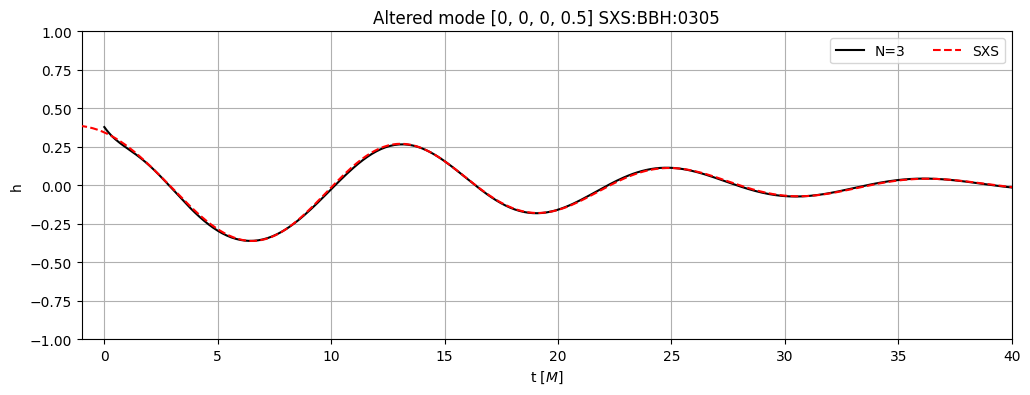

In [6]:
for (sim,ind) in zip(sims,ids):
    sim = sims[0]
    fig, ax = plt.subplots(figsize=(12,4))

    k = 4
    deltas = [0,0,0,0.5]

    colors = cm.batlow(np.linspace(0,1,k))
    modes = [(2,2,n,1) for n in range(k)]
    fit = qnmfits.ringdown_fit_delta(
        sim.times,
        sim.h[2,2],
        modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0=0,
        deltas=deltas
    )


    ax.plot(fit['model_times'], np.real(fit['model']), alpha = 1, label =  "N="+ str(k-1), color="black")#colors[i], zorder=i)

    # Plot the original waveform
    ax.plot(sim.times, np.real(sim.h[2,2]), label="SXS", linestyle='dashed', color="red",zorder=100)

    # Formatting
    ax.grid(which='both')
    ax.set_title(r'Altered mode ' + str(deltas) + ' SXS:BBH:' + f'{ind:04}')
    ax.set_xlabel(r't [$M$]')
    ax.set_ylabel('h')
    ax.legend(loc='upper right',ncol=2)
    ax.set_xlim(-1,40)
    ax.set_ylim(-1,1)

    plt.savefig('waveqnmovertones.png', dpi=500, bbox_inches='tight')
    #Save figure
    if not os.path.exists(overtonedelta_dir):
        os.makedirs(overtonedelta_dir)
    plt.savefig(overtonedelta_dir + 'overtonedelta' + f'{ind:04}' + '.png', dpi=500, bbox_inches='tight')
    print('Saved overtonedelta' + f'{ind:04}' + '.png')

In [7]:
k = 7

deltas = [0,0,0,0,0,0,0]

modes = [(2,2,n,1) for n in range(k)]
eps = qnmfits.calculate_epsilon_delta(
            sim.times,
            sim.h[2,2],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=0,
            deltas=deltas
        )


print(eps)
print(sim.Mf,sim.chif_mag)



(0.0005641282086747129, 0.9523471005626234, 0.6925537416074685)
0.952032939704 0.6920851868180025


In [8]:
k = 3
d = [0.01,0.05,0.20]

for i in range(k):
    for nm in range(1, k+1):
        zeros = np.zeros(k)
        zeros[-nm] = d[i]
        deltas = zeros
        print(deltas)
    

[0.   0.   0.01]
[0.   0.01 0.  ]
[0.01 0.   0.  ]
[0.   0.   0.05]
[0.   0.05 0.  ]
[0.05 0.   0.  ]
[0.  0.  0.2]
[0.  0.2 0. ]
[0.2 0.  0. ]


[0] 0.3088613107718283
[0, 0] 0.08859297883154951
[0, 0, 0] 0.02701147958164799
[0, 0, 0, 0] 0.008555877478888566
[0, 0, 0, 0, 0] 0.0028894998297935705
[0, 0, 0, 0, 0, 0] 0.0009594141449334409
[0, 0, 0, 0, 0, 0, 0] 0.0005641282086747129
[0, 0, 0, 0, 0, 0, 0, 0] 0.0003376298216387589
[0] 0.3088613107718283
[0, 0.01] 0.08809622218284553
[0, 0.01, 0.01] 0.026656355697297105
[0, 0.01, 0.01, 0.01] 0.009075042874833725
[0, 0.01, 0.01, 0.01, 0.01] 0.004369435819481316
[0, 0.01, 0.01, 0.01, 0.01, 0.01] 0.002539350358630577
[0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01] 0.0018632486753953892
[0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01] 0.0019557574183128998
[0] 0.3088613107718283
[0, 0.05] 0.08881280014912839
[0, 0.05, 0.05] 0.02860886111054409
[0, 0.05, 0.05, 0.05] 0.015144575158257739
[0, 0.05, 0.05, 0.05, 0.05] 0.012845976179248169
[0, 0.05, 0.05, 0.05, 0.05, 0.05] 0.011285550333976234
[0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05] 0.009970907453902451
[0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05] 0.0090

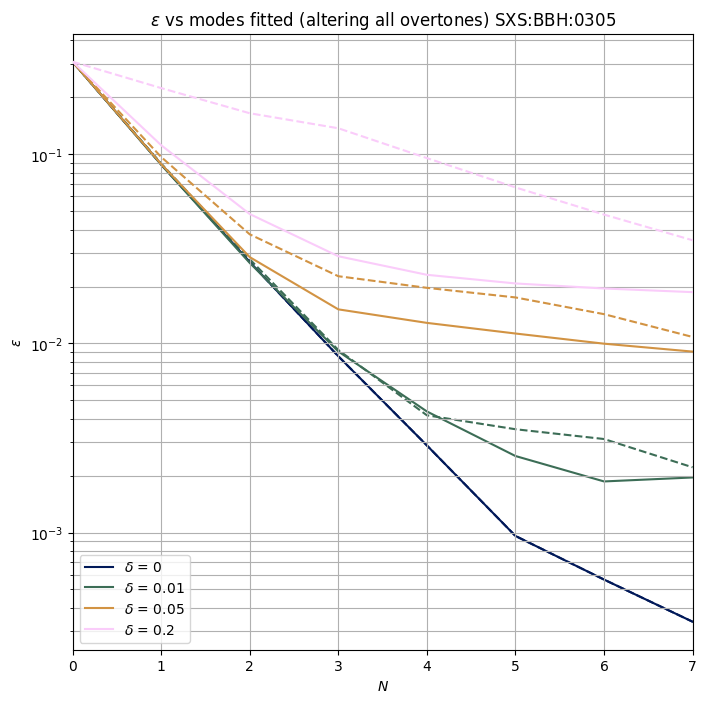

In [28]:
for (sim,ind) in zip(sims,ids):
    fig, ax = plt.subplots(figsize=(8,8))
    d = [0,0.01,0.05,0.20]
    k = 8
    N = np.arange(k)

    colors = cm.batlow(np.linspace(0,1,len(d)))
    
    # Plot the +delta case
    for i,delta in enumerate(d):
        epsilons = []
        for k in range(1,9):
            #zeros = np.zeros(k)
            #zeros[-1] = delta
            #deltas = zeros
            deltas = [delta]*k
            deltas[0] = 0
            modes = [(2,2,n,1) for n in range(k)]
            eps = qnmfits.calculate_epsilon_delta(
                        sim.times,
                        sim.h[2,2],
                        modes,
                        Mf=sim.Mf,
                        chif=sim.chif_mag,
                        t0=0,
                        deltas=deltas
                    )
            print(deltas,eps[0])
            epsilons.append(eps[0])
        
        ax.plot(N,epsilons,label=r'$\delta$ = ' + str(delta),color=colors[i],zorder=i)


    # Plot the -delta case
    for i,delta in enumerate(d):
        epsilons = []
        for k in range(1,9):
            #zeros = np.zeros(k)
            #zeros[-1] = delta
            #deltas = zeros
            deltas = [-delta]*k
            deltas[0] = 0
            modes = [(2,2,n,1) for n in range(k)]
            eps = qnmfits.calculate_epsilon_delta(
                        sim.times,
                        sim.h[2,2],
                        modes,
                        Mf=sim.Mf,
                        chif=sim.chif_mag,
                        t0=0,
                        deltas=deltas
                    )
            print(deltas,eps[0])
            epsilons.append(eps[0])
            
        ax.plot(N,epsilons,linestyle='--',color=colors[i],zorder=i)



    ax.grid(which='both')
    ax.set_title(r'$\epsilon$ vs modes fitted (altering all overtones)' + ' SXS:BBH:' + f'{ind:04}')
    ax.set_xlabel(r'$N$')
    ax.set_ylabel(r'$\epsilon$')
    ax.legend(loc='lower left')#,ncol=2)
    ax.set_xlim(0,7)
    #ax.set_ylim(-1,1)
    ax.set_yscale('log')



[0.]
[0.   0.01]
[0.   0.01 0.01]
[0.   0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0.   0.   0.01]
[0.   0.   0.01 0.01]
[0.   0.   0.01 0.01 0.01]
[0.   0.   0.01 0.01 0.01 0.01]
[0.   0.   0.01 0.01 0.01 0.01 0.01]
[0.   0.   0.01 0.01 0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0.   0.   0.   0.01]
[0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.01 0.01 0.01]
[0.   0.   0.   0.01 0.01 0.01 0.01]
[0.   0.   0.   0.01 0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0.   0.   0.   0.   0.01]
[0.   0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.   0.01 0.01 0.01]
[0.   0.   0.   0.   0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.   0.01]
[0.   0.   0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.   0.   0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.   0.   0.  

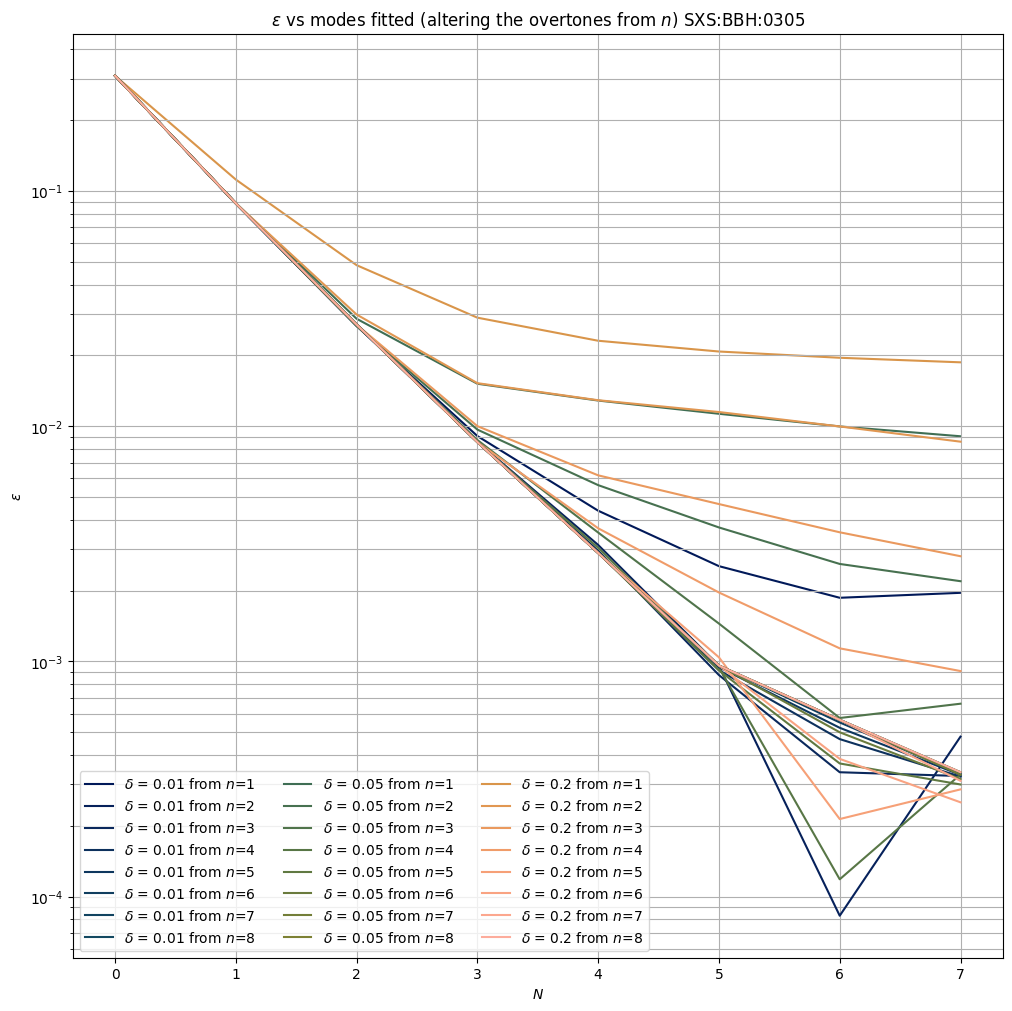

In [10]:

fig, ax = plt.subplots(figsize=(12,12))

N = 9
d = [0.01,0.05,0.20]


originalcolors = cm.batlow(np.linspace(0,1,2*(N-1)*len(d)))
# Slice into 6 even length sublists
sublists = [originalcolors[i:i+len(originalcolors)//6] for i in range(0, len(originalcolors), len(originalcolors)//6)]

# Compile the first, third, and fifth sublist into a single list
colors = [item for sublist_index, sublist in enumerate(sublists) if sublist_index % 2 == 0 for item in sublist]


cind = 0
for delta in d:
    for i in range(1,N):
        epsilons = []
        for k in range(1,N):
            zeros = np.zeros(k)
            zeros[i:] = delta
            deltas = zeros
            
            modes = [(2,2,n,1) for n in range(k)]
            eps = qnmfits.calculate_epsilon_delta(
                        sim.times,
                        sim.h[2,2],
                        modes,
                        Mf=sim.Mf,
                        chif=sim.chif_mag,
                        t0=0,
                        deltas=deltas
                    )
            #print(deltas,eps[0])
            print(deltas)
            epsilons.append(eps[0])
            
        ax.plot(np.arange(k),epsilons,label=r'$\delta$ = ' + str(delta) + r' from $n$=' + str(i),color=colors[cind],zorder=i)
        cind += 1


ax.grid(which='both')
ax.set_title(r'$\epsilon$ vs modes fitted (altering the overtones from $n$)' + ' SXS:BBH:' + f'{ind:04}')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\epsilon$')
ax.legend(loc='lower left',ncol=3)
#ax.set_xlim(-1,40)
#ax.set_ylim(7e-6,1e0)
ax.set_yscale('log')



[0.]
[0.   0.01]
[0.   0.01 0.01]
[0.   0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0.   0.   0.01]
[0.   0.   0.01 0.01]
[0.   0.   0.01 0.01 0.01]
[0.   0.   0.01 0.01 0.01 0.01]
[0.   0.   0.01 0.01 0.01 0.01 0.01]
[0.   0.   0.01 0.01 0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0.   0.   0.   0.01]
[0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.01 0.01 0.01]
[0.   0.   0.   0.01 0.01 0.01 0.01]
[0.   0.   0.   0.01 0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0.   0.   0.   0.   0.01]
[0.   0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.   0.01 0.01 0.01]
[0.   0.   0.   0.   0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.   0.01]
[0.   0.   0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.   0.   0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.   0.   0.  

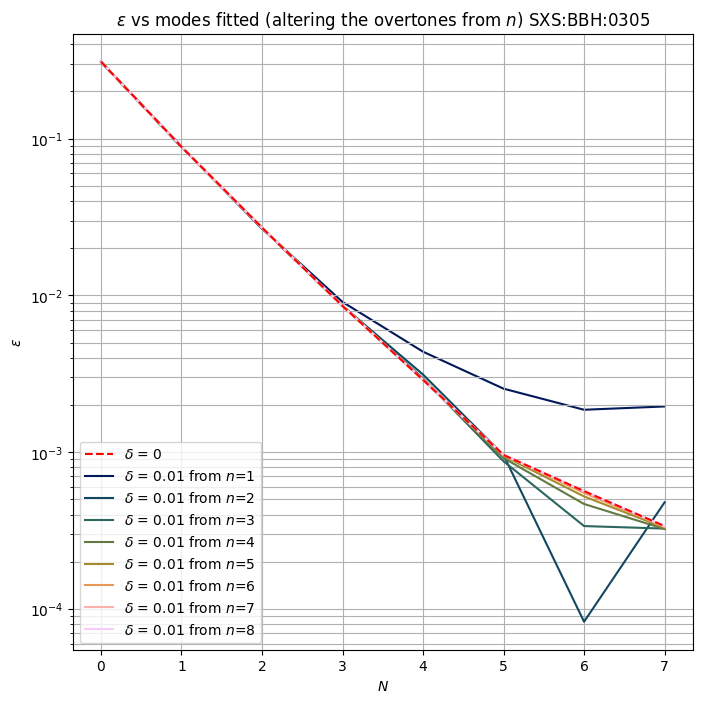

In [11]:

fig, ax = plt.subplots(figsize=(8,8))

N = 9
d = [0.01]#,0.05,0.20]


for i in range(1,N):
    epsilons = []
    for k in range(1,N):
        deltas = np.zeros(k)
        
        modes = [(2,2,n,1) for n in range(k)]
        eps = qnmfits.calculate_epsilon_delta(
                    sim.times,
                    sim.h[2,2],
                    modes,
                    Mf=sim.Mf,
                    chif=sim.chif_mag,
                    t0=0,
                    deltas=deltas
                )
        epsilons.append(eps[0])

ax.plot(np.arange(k),epsilons,label=r'$\delta$ = 0',linestyle='--',color='red',zorder=10000)



colors = cm.batlow(np.linspace(0,1,(N-1)*len(d)))


for delta in d:
    for i in range(1,N):
        epsilons = []
        for k in range(1,N):
            zeros = np.zeros(k)
            zeros[i:] = delta
            deltas = zeros
            
            modes = [(2,2,n,1) for n in range(k)]
            eps = qnmfits.calculate_epsilon_delta(
                        sim.times,
                        sim.h[2,2],
                        modes,
                        Mf=sim.Mf,
                        chif=sim.chif_mag,
                        t0=0,
                        deltas=deltas
                    )
            #print(deltas,eps[0])
            print(deltas)
            epsilons.append(eps[0])
            
        ax.plot(np.arange(k),epsilons,label=r'$\delta$ = ' + str(delta) + r' from $n$=' + str(i),color=colors[i-1],zorder=i)



ax.grid(which='both')
ax.set_title(r'$\epsilon$ vs modes fitted (altering the overtones from $n$)' + ' SXS:BBH:' + f'{ind:04}')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\epsilon$')
ax.legend(loc='lower left')#,ncol=2)
#ax.set_xlim(-1,40)
#ax.set_ylim(7e-6,1e0)
ax.set_yscale('log')



[0.]
[0.   0.05]
[0.   0.05 0.05]
[0.   0.05 0.05 0.05]
[0.   0.05 0.05 0.05 0.05]
[0.   0.05 0.05 0.05 0.05 0.05]
[0.   0.05 0.05 0.05 0.05 0.05 0.05]
[0.   0.05 0.05 0.05 0.05 0.05 0.05 0.05]
[0.]
[0. 0.]
[0.   0.   0.05]
[0.   0.   0.05 0.05]
[0.   0.   0.05 0.05 0.05]
[0.   0.   0.05 0.05 0.05 0.05]
[0.   0.   0.05 0.05 0.05 0.05 0.05]
[0.   0.   0.05 0.05 0.05 0.05 0.05 0.05]
[0.]
[0. 0.]
[0. 0. 0.]
[0.   0.   0.   0.05]
[0.   0.   0.   0.05 0.05]
[0.   0.   0.   0.05 0.05 0.05]
[0.   0.   0.   0.05 0.05 0.05 0.05]
[0.   0.   0.   0.05 0.05 0.05 0.05 0.05]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0.   0.   0.   0.   0.05]
[0.   0.   0.   0.   0.05 0.05]
[0.   0.   0.   0.   0.05 0.05 0.05]
[0.   0.   0.   0.   0.05 0.05 0.05 0.05]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.   0.05]
[0.   0.   0.   0.   0.   0.05 0.05]
[0.   0.   0.   0.   0.   0.05 0.05 0.05]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.   0.   0.  

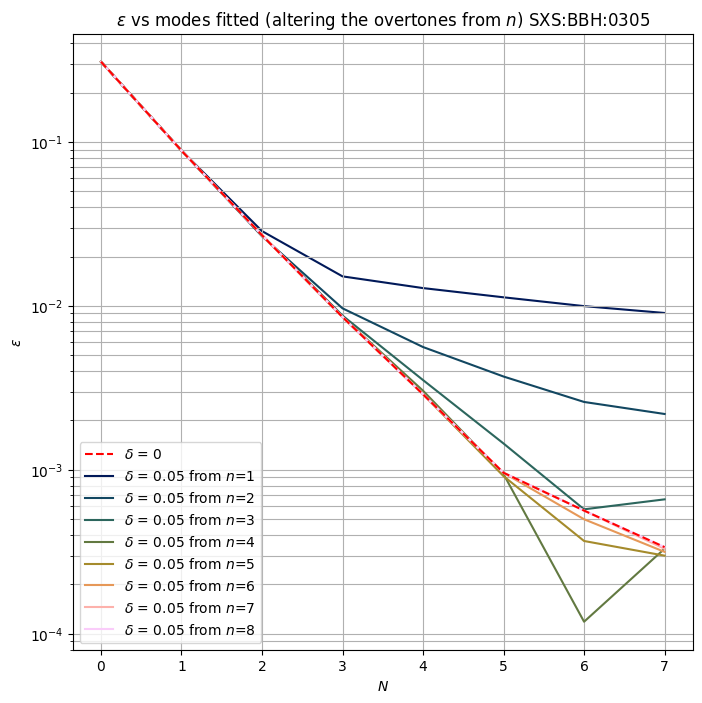

In [12]:

fig, ax = plt.subplots(figsize=(8,8))

N = 9
d = [0.05]


for i in range(1,N):
    epsilons = []
    for k in range(1,N):
        deltas = np.zeros(k)
        
        modes = [(2,2,n,1) for n in range(k)]
        eps = qnmfits.calculate_epsilon_delta(
                    sim.times,
                    sim.h[2,2],
                    modes,
                    Mf=sim.Mf,
                    chif=sim.chif_mag,
                    t0=0,
                    deltas=deltas
                )
        epsilons.append(eps[0])

ax.plot(np.arange(k),epsilons,label=r'$\delta$ = 0',linestyle='--',color='red',zorder=10000)



colors = cm.batlow(np.linspace(0,1,(N-1)*len(d)))


for delta in d:
    for i in range(1,N):
        epsilons = []
        for k in range(1,N):
            zeros = np.zeros(k)
            zeros[i:] = delta
            deltas = zeros
            
            modes = [(2,2,n,1) for n in range(k)]
            eps = qnmfits.calculate_epsilon_delta(
                        sim.times,
                        sim.h[2,2],
                        modes,
                        Mf=sim.Mf,
                        chif=sim.chif_mag,
                        t0=0,
                        deltas=deltas
                    )
            #print(deltas,eps[0])
            print(deltas)
            epsilons.append(eps[0])
            
        ax.plot(np.arange(k),epsilons,label=r'$\delta$ = ' + str(delta) + r' from $n$=' + str(i),color=colors[i-1],zorder=i)



ax.grid(which='both')
ax.set_title(r'$\epsilon$ vs modes fitted (altering the overtones from $n$)' + ' SXS:BBH:' + f'{ind:04}')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\epsilon$')
ax.legend(loc='lower left')#,ncol=2)
#ax.set_xlim(-1,40)
#ax.set_ylim(7e-6,1e0)
ax.set_yscale('log')



[0.]
[0.  0.2]
[0.  0.2 0.2]
[0.  0.2 0.2 0.2]
[0.  0.2 0.2 0.2 0.2]
[0.  0.2 0.2 0.2 0.2 0.2]
[0.  0.2 0.2 0.2 0.2 0.2 0.2]
[0.  0.2 0.2 0.2 0.2 0.2 0.2 0.2]
[0.]
[0. 0.]
[0.  0.  0.2]
[0.  0.  0.2 0.2]
[0.  0.  0.2 0.2 0.2]
[0.  0.  0.2 0.2 0.2 0.2]
[0.  0.  0.2 0.2 0.2 0.2 0.2]
[0.  0.  0.2 0.2 0.2 0.2 0.2 0.2]
[0.]
[0. 0.]
[0. 0. 0.]
[0.  0.  0.  0.2]
[0.  0.  0.  0.2 0.2]
[0.  0.  0.  0.2 0.2 0.2]
[0.  0.  0.  0.2 0.2 0.2 0.2]
[0.  0.  0.  0.2 0.2 0.2 0.2 0.2]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0.  0.  0.  0.  0.2]
[0.  0.  0.  0.  0.2 0.2]
[0.  0.  0.  0.  0.2 0.2 0.2]
[0.  0.  0.  0.  0.2 0.2 0.2 0.2]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.  0.2]
[0.  0.  0.  0.  0.  0.2 0.2]
[0.  0.  0.  0.  0.  0.2 0.2 0.2]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.  0.  0.2]
[0.  0.  0.  0.  0.  0.  0.2 0.2]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.

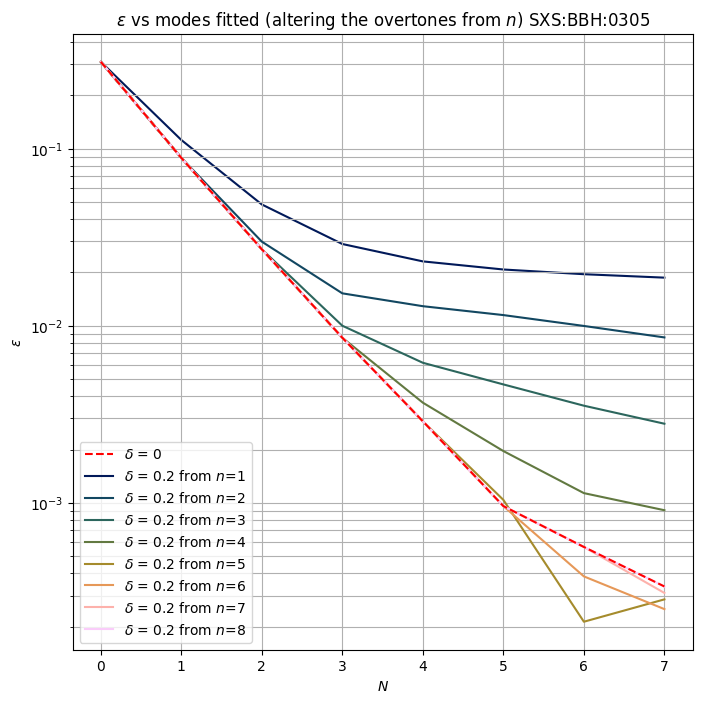

In [13]:

fig, ax = plt.subplots(figsize=(8,8))

N = 9
d = [0.20]


for i in range(1,N):
    epsilons = []
    for k in range(1,N):
        deltas = np.zeros(k)
        
        modes = [(2,2,n,1) for n in range(k)]
        eps = qnmfits.calculate_epsilon_delta(
                    sim.times,
                    sim.h[2,2],
                    modes,
                    Mf=sim.Mf,
                    chif=sim.chif_mag,
                    t0=0,
                    deltas=deltas
                )
        epsilons.append(eps[0])

ax.plot(np.arange(k),epsilons,label=r'$\delta$ = 0',linestyle='--',color='red',zorder=10000)



colors = cm.batlow(np.linspace(0,1,(N-1)*len(d)))


for delta in d:
    for i in range(1,N):
        epsilons = []
        for k in range(1,N):
            zeros = np.zeros(k)
            zeros[i:] = delta
            deltas = zeros
            
            modes = [(2,2,n,1) for n in range(k)]
            eps = qnmfits.calculate_epsilon_delta(
                        sim.times,
                        sim.h[2,2],
                        modes,
                        Mf=sim.Mf,
                        chif=sim.chif_mag,
                        t0=0,
                        deltas=deltas
                    )
            #print(deltas,eps[0])
            print(deltas)
            epsilons.append(eps[0])
            
        ax.plot(np.arange(k),epsilons,label=r'$\delta$ = ' + str(delta) + r' from $n$=' + str(i),color=colors[i-1],zorder=i)



ax.grid(which='both')
ax.set_title(r'$\epsilon$ vs modes fitted (altering the overtones from $n$)' + ' SXS:BBH:' + f'{ind:04}')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\epsilon$')
ax.legend(loc='lower left')#,ncol=2)
#ax.set_xlim(-1,40)
#ax.set_ylim(7e-6,1e0)
ax.set_yscale('log')



[0.]
[0.   0.01]
[0.   0.01 0.01]
[0.   0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01 0.01 0.01]
[0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0.   0.   0.01]
[0.   0.   0.01 0.01]
[0.   0.   0.01 0.01 0.01]
[0.   0.   0.01 0.01 0.01 0.01]
[0.   0.   0.01 0.01 0.01 0.01 0.01]
[0.   0.   0.01 0.01 0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0.   0.   0.   0.01]
[0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.01 0.01 0.01]
[0.   0.   0.   0.01 0.01 0.01 0.01]
[0.   0.   0.   0.01 0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0.   0.   0.   0.   0.01]
[0.   0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.   0.01 0.01 0.01]
[0.   0.   0.   0.   0.01 0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.   0.01]
[0.   0.   0.   0.   0.   0.01 0.01]
[0.   0.   0.   0.   0.   0.01 0.01 0.01]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0.   0.   0.  

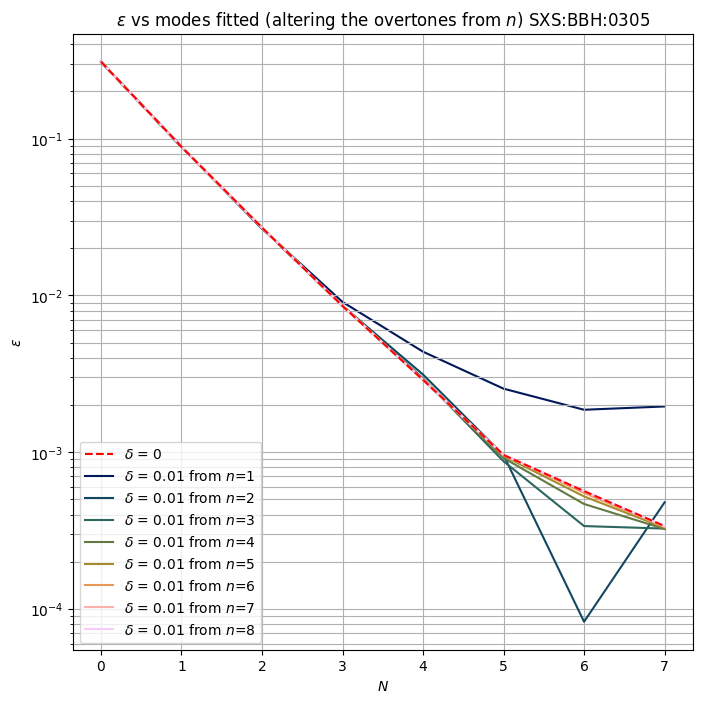

In [14]:

fig, ax = plt.subplots(figsize=(8,8))

N = 9
d = [0.01]#,0.05,0.20]


for i in range(1,N):
    epsilons = []
    for k in range(1,N):
        deltas = np.zeros(k)
        
        modes = [(2,2,n,1) for n in range(k)]
        eps = qnmfits.calculate_epsilon_delta(
                    sim.times,
                    sim.h[2,2],
                    modes,
                    Mf=sim.Mf,
                    chif=sim.chif_mag,
                    t0=0,
                    deltas=deltas
                )
        epsilons.append(eps[0])

ax.plot(np.arange(k),epsilons,label=r'$\delta$ = 0',linestyle='--',color='red',zorder=10000)



colors = cm.batlow(np.linspace(0,1,(N-1)*len(d)))


for delta in d:
    for i in range(1,N):
        epsilons = []
        for k in range(1,N):
            zeros = np.zeros(k)
            zeros[i:] = delta
            deltas = zeros
            
            modes = [(2,2,n,1) for n in range(k)]
            eps = qnmfits.calculate_epsilon_delta(
                        sim.times,
                        sim.h[2,2],
                        modes,
                        Mf=sim.Mf,
                        chif=sim.chif_mag,
                        t0=0,
                        deltas=deltas
                    )
            #print(deltas,eps[0])
            print(deltas)
            epsilons.append(eps[0])
            
        ax.plot(np.arange(k),epsilons,label=r'$\delta$ = ' + str(delta) + r' from $n$=' + str(i),color=colors[i-1],zorder=i)



ax.grid(which='both')
ax.set_title(r'$\epsilon$ vs modes fitted (altering the overtones from $n$)' + ' SXS:BBH:' + f'{ind:04}')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\epsilon$')
ax.legend(loc='lower left')#,ncol=2)
#ax.set_xlim(-1,40)
#ax.set_ylim(7e-6,1e0)
ax.set_yscale('log')



[0.]
[0. 1.]
[0. 1. 1.]
[0. 1. 1. 1.]
[0. 1. 1. 1. 1.]
[0. 1. 1. 1. 1. 1.]
[0. 1. 1. 1. 1. 1. 1.]
[0. 1. 1. 1. 1. 1. 1. 1.]
[0.]
[0. 0.]
[0. 0. 1.]
[0. 0. 1. 1.]
[0. 0. 1. 1. 1.]
[0. 0. 1. 1. 1. 1.]
[0. 0. 1. 1. 1. 1. 1.]
[0. 0. 1. 1. 1. 1. 1. 1.]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 1. 1.]
[0. 0. 0. 1. 1. 1.]
[0. 0. 0. 1. 1. 1. 1.]
[0. 0. 0. 1. 1. 1. 1. 1.]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 1.]
[0. 0. 0. 0. 1. 1. 1.]
[0. 0. 0. 0. 1. 1. 1. 1.]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 1.]
[0. 0. 0. 0. 0. 1. 1. 1.]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 1. 1.]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]
[0.]
[0. 0.]
[0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]


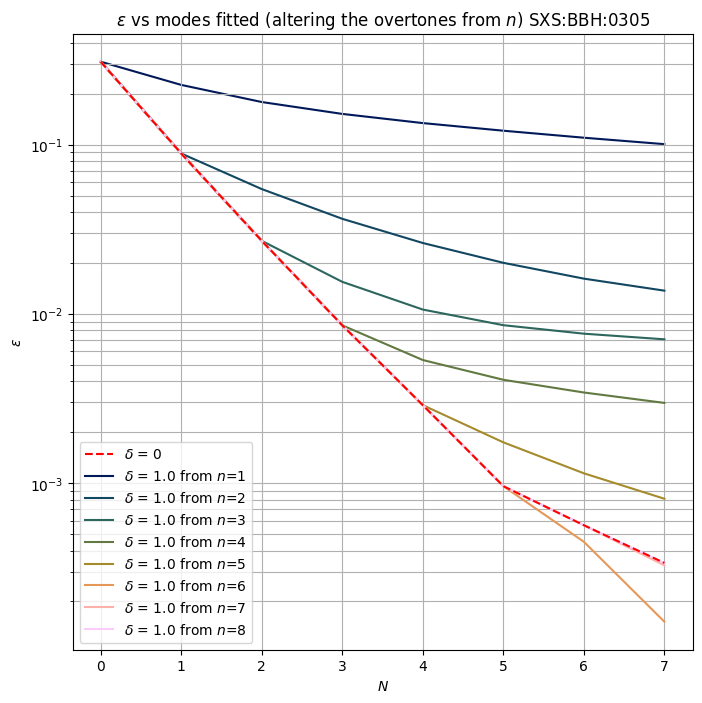

In [32]:

fig, ax = plt.subplots(figsize=(8,8))

N = 9
d = [1.0]


for i in range(1,N):
    epsilons = []
    for k in range(1,N):
        deltas = np.zeros(k)
        
        modes = [(2,2,n,1) for n in range(k)]
        eps = qnmfits.calculate_epsilon_delta(
                    sim.times,
                    sim.h[2,2],
                    modes,
                    Mf=sim.Mf,
                    chif=sim.chif_mag,
                    t0=0,
                    deltas=deltas
                )
        epsilons.append(eps[0])

ax.plot(np.arange(k),epsilons,label=r'$\delta$ = 0',linestyle='--',color='red',zorder=10000)



colors = cm.batlow(np.linspace(0,1,(N-1)*len(d)))


for delta in d:
    for i in range(1,N):
        epsilons = []
        for k in range(1,N):
            zeros = np.zeros(k)
            zeros[i:] = delta
            deltas = zeros
            
            modes = [(2,2,n,1) for n in range(k)]
            eps = qnmfits.calculate_epsilon_delta(
                        sim.times,
                        sim.h[2,2],
                        modes,
                        Mf=sim.Mf,
                        chif=sim.chif_mag,
                        t0=0,
                        deltas=deltas
                    )
            #print(deltas,eps[0])
            print(deltas)
            epsilons.append(eps[0])
            
        ax.plot(np.arange(k),epsilons,label=r'$\delta$ = ' + str(delta) + r' from $n$=' + str(i),color=colors[i-1],zorder=i)



ax.grid(which='both')
ax.set_title(r'$\epsilon$ vs modes fitted (altering the overtones from $n$)' + ' SXS:BBH:' + f'{ind:04}')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\epsilon$')
ax.legend(loc='lower left')#,ncol=2)
#ax.set_xlim(-1,40)
#ax.set_ylim(7e-6,1e0)
ax.set_yscale('log')



In [ ]:

fig, ax = plt.subplots(figsize=(8,8))

N = 9
d = [1.0]


for i in range(1,N):
    epsilons = []
    for k in range(1,N):
        deltas = np.zeros(k)
        
        modes = [(2,2,n,1) for n in range(k)]
        eps = qnmfits.calculate_epsilon_delta(
                    sim.times,
                    sim.h[2,2],
                    modes,
                    Mf=sim.Mf,
                    chif=sim.chif_mag,
                    t0=0,
                    deltas=deltas
                )
        epsilons.append(eps[0])

ax.plot(np.arange(k),epsilons,label=r'$\delta$ = 0',linestyle='--',color='red',zorder=10000)



colors = cm.batlow(np.linspace(0,1,(N-1)*len(d)))


for delta in d:
    for i in range(1,N):
        epsilons = []
        for k in range(1,N):
            zeros = np.zeros(k)
            zeros[i:] = delta
            deltas = zeros
            
            modes = [(2,2,n,1) for n in range(k)]
            eps = qnmfits.calculate_epsilon_delta(
                        sim.times,
                        sim.h[2,2],
                        modes,
                        Mf=sim.Mf,
                        chif=sim.chif_mag,
                        t0=0,
                        deltas=deltas
                    )
            #print(deltas,eps[0])
            print(deltas)
            epsilons.append(eps[0])
            
        ax.plot(np.arange(k),epsilons,label=r'$\delta$ = ' + str(delta) + r' from $n$=' + str(i),color=colors[i-1],zorder=i)



ax.grid(which='both')
ax.set_title(r'$\epsilon$ vs modes fitted (altering the overtones from $n$)' + ' SXS:BBH:' + f'{ind:04}')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\epsilon$')
ax.legend(loc='lower left')#,ncol=2)
#ax.set_xlim(-1,40)
#ax.set_ylim(7e-6,1e0)
ax.set_yscale('log')



In [25]:
N = 100
x = np.linspace(0.5,0.9,num=N)
y = np.linspace(0.85,1,num=N)

print(y)
print(y[0::10])

[0.85       0.85151515 0.8530303  0.85454545 0.85606061 0.85757576
 0.85909091 0.86060606 0.86212121 0.86363636 0.86515152 0.86666667
 0.86818182 0.86969697 0.87121212 0.87272727 0.87424242 0.87575758
 0.87727273 0.87878788 0.88030303 0.88181818 0.88333333 0.88484848
 0.88636364 0.88787879 0.88939394 0.89090909 0.89242424 0.89393939
 0.89545455 0.8969697  0.89848485 0.9        0.90151515 0.9030303
 0.90454545 0.90606061 0.90757576 0.90909091 0.91060606 0.91212121
 0.91363636 0.91515152 0.91666667 0.91818182 0.91969697 0.92121212
 0.92272727 0.92424242 0.92575758 0.92727273 0.92878788 0.93030303
 0.93181818 0.93333333 0.93484848 0.93636364 0.93787879 0.93939394
 0.94090909 0.94242424 0.94393939 0.94545455 0.9469697  0.94848485
 0.95       0.95151515 0.9530303  0.95454545 0.95606061 0.95757576
 0.95909091 0.96060606 0.96212121 0.96363636 0.96515152 0.96666667
 0.96818182 0.96969697 0.97121212 0.97272727 0.97424242 0.97575758
 0.97727273 0.97878788 0.98030303 0.98181818 0.98333333 0.98484

In [16]:
N = 100
x, y = np.mgrid[0.50:0.90:complex(0,N), 0.85:1:complex(0,N)]
print(x.ravel())
print(y.ravel())

[0.5 0.5 0.5 ... 0.9 0.9 0.9]
[0.85       0.85151515 0.8530303  ... 0.9969697  0.99848485 1.        ]


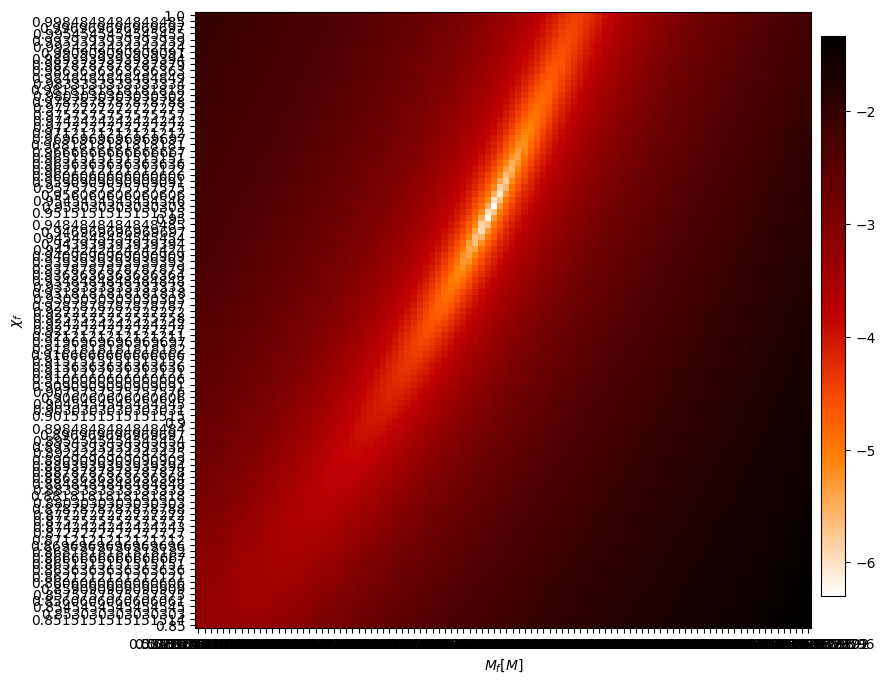

In [27]:
comb = []
for (sim,ind) in zip(sims,ids):
    fig, ax = plt.subplots(figsize=(8,8))
    
    k = 7
    
    N = 100
    x = np.linspace(0.5,0.9,num=N)
    y = np.linspace(0.85,1,num=N)
    
    Ms = []

    for j in y:
        Mss = []
        for i in x:
            modes = [(2,2,n,1) for n in range(k)]
            fit = qnmfits.ringdown_fit(
                sim.times,
                sim.h[2,2],
                modes,
                Mf=j,
                chif=i,
                t0=0,
                t0_method = 'closest'
            )
            Mss.append(fit['mismatch'])
        Ms.append(Mss)
            

    logMs = np.log(Ms)/np.log(10)
    im = ax.imshow(logMs, cmap='gist_heat_r', interpolation='none', origin='lower')


    # Creating the colorbar with explicit size
    cbar_ax = fig.add_axes([0.91, 0.15, 0.03, 0.7])  # Adjust the position and size as needed
    cbar = plt.colorbar(im, cax=cbar_ax)



    # Reassigning x-axis and y-axis labels
    # Example labels for x and y axes
    x_labels = np.linspace(0.5, 0.9, num=len(logMs[0]))
    y_labels = np.linspace(0.85, 1, num=len(logMs))

    # Set the tick locations and labels for the x-axis
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels)

    # Set the tick locations and labels for the y-axis
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels)



    # Set x and y axis labels
    ax.set_xlabel(r'$M_f[M]$')
    ax.set_ylabel(r'$\chi_f$')


    #ax.grid(which='both')
    #ax.set_title(r'Mismatch for no. of modes fitted with peaks (kneedle) SXS:BBH:' + f'{ind:04}')
    #ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
    #ax.set_ylabel('$\mathcal{M}$')
    #ax.legend(loc='lower right')
    #ax.set_yscale('log')

    #ax.set_xlim(-11,-8)
    #ax.set_ylim(-7,-6)

    #_ = ax.legend(ncol=2, frameon=False, fontsize=7)
    #plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')
    # Save figure
    #if not os.path.exists(mismatch_dir):
    #    os.makedirs(mismatch_dir)
    #plt.savefig(mismatch_dir + 'mismatchpeakskneedle' + f'{ind:04}' + '.png', dpi=500, bbox_inches='tight')
    #print('Saved mismatchpeakskneedle' + f'{ind:04}' + '.png')
